In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2011.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2013.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2015.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2014.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2009.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2017.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2012.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2010.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2018.csv
/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2016.csv


In [2]:
import pandas as pd
import seaborn as sns
import datetime
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from matplotlib.pyplot import figure

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
files = glob.glob('/kaggle/input/airline-delay-and-cancellation-data-2009-2018/*.csv',recursive = True)
dfs = list()
for i, f in enumerate(files):
    if f=='/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2018.csv':
        break
    data = pd.read_csv(f, usecols=['FL_DATE', 'DEP_DELAY', 'OP_CARRIER'])
    data['file'] = f'File {i}'
    dfs.append(data)
    
df = pd.concat(dfs, ignore_index=True)

df
# dfnew = pd.read_csv('/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2009.csv' , usecols=['FL_DATE', 'DEP_DELAY', 'OP_CARRIER'])
# dfnew

,FL_DATE,OP_CARRIER,DEP_DELAY,file
0,2011-01-01,MQ,-7.0,File 0
1,2011-01-01,MQ,-8.0,File 0
2,2011-01-01,MQ,-2.0,File 0
3,2011-01-01,MQ,-4.0,File 0
4,2011-01-01,MQ,0.0,File 0
...,...,...,...,...
48725855,2010-12-31,US,-8.0,File 7
48725856,2010-12-31,US,-3.0,File 7
48725857,2010-12-31,US,-8.0,File 7
48725858,2010-12-31,US,-1.0,File 7


In [4]:
dfnew = df.groupby(['FL_DATE','OP_CARRIER']).mean().reset_index()
df2=dfnew[dfnew['OP_CARRIER']=='WN']
df2=df2[['DEP_DELAY','FL_DATE']]
df2['FL_DATE'] = pd.to_datetime(df2['FL_DATE'])
df2.set_index(['FL_DATE'], inplace=True)
df2

,DEP_DELAY
FL_DATE,
2009-01-01,5.950759
2009-01-02,13.607993
2009-01-03,14.120028
2009-01-04,21.233322
2009-01-05,20.033832
...,...
2017-12-27,23.585164
2017-12-28,16.141201
2017-12-29,18.553609


In [5]:
dftest = pd.read_csv('/kaggle/input/airline-delay-and-cancellation-data-2009-2018/2018.csv', usecols=['FL_DATE', 'DEP_DELAY', 'OP_CARRIER'])
dftest = dftest.groupby(['FL_DATE','OP_CARRIER']).mean().reset_index()
dftest2=dftest[dftest['OP_CARRIER']=='WN']
dftest2=dftest2[['DEP_DELAY','FL_DATE']]
dftest2['FL_DATE'] = pd.to_datetime(dftest2['FL_DATE'])
dftest2.set_index(['FL_DATE'], inplace=True)
dftest2

,DEP_DELAY
FL_DATE,
2018-01-01,23.024846
2018-01-02,15.350932
2018-01-03,12.566578
2018-01-04,6.509660
2018-01-05,7.558038
...,...
2018-12-27,33.942715
2018-12-28,26.461115
2018-12-29,21.579760


In [6]:
from pandas.plotting import autocorrelation_plot

result = adfuller(df2.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.084660292214482
p-value: 1.0715545834924619e-07
Critial Values:
   1%, -3.4326628061366975
Critial Values:
   5%, -2.8625618378489444
Critial Values:
   10%, -2.56731395497509


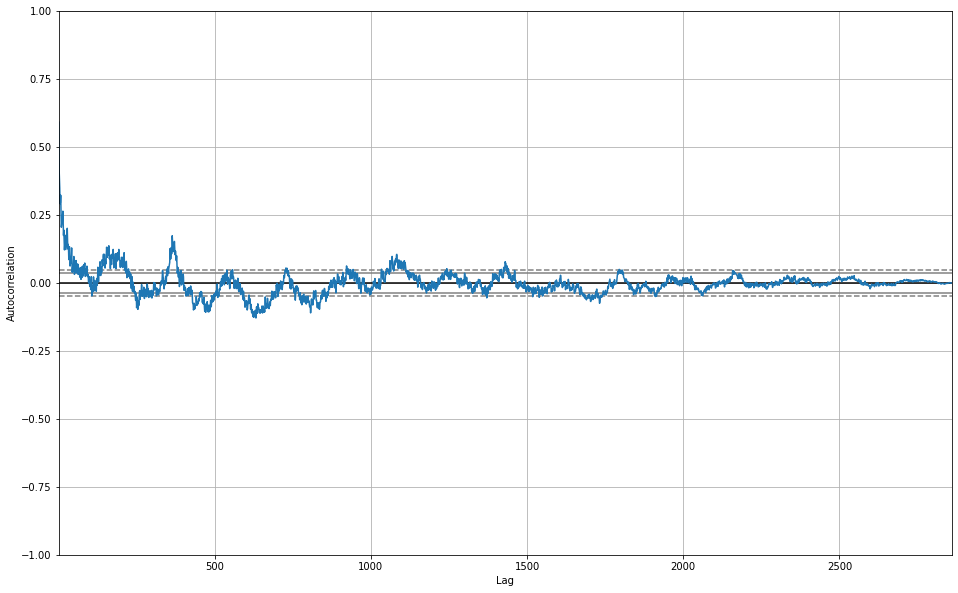

In [7]:
plt.figure(figsize=(16, 10))
autocorrelation_plot(df2)
plt.show()

Based on p-values, its evident that ADF concludes given series is stationary while KPSS concludes non-stationary. Hence, the differenced series needs to be checked for stationarity.

In [8]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(df2)

Results of KPSS Test:
Test Statistic            0.450113
p-value                   0.055555
#Lags Used               27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [9]:
model = ARIMA(df2, order=(27,0,0))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              DEP_DELAY   No. Observations:                 2859
Model:                ARIMA(27, 0, 0)   Log Likelihood               -8951.685
Date:                Tue, 30 Aug 2022   AIC                          17961.370
Time:                        01:38:21   BIC                          18134.159
Sample:                             0   HQIC                         18023.674
                               - 2859                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9834      0.783     14.019      0.000       9.448      12.519
ar.L1          0.4842      0.014     34.437      0.000       0.457       0.512
ar.L2          0.0212      0.018      1.189      0.2

In [10]:
from sklearn.metrics import mean_squared_error

X = df2.values
Y = dftest2.values
size = int(len(X))
train, test = X, Y
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(27,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=13.882537, expected=23.024846
predicted=19.608652, expected=15.350932
predicted=15.784108, expected=12.566578
predicted=13.056275, expected=6.509660
predicted=11.122613, expected=7.558038
predicted=10.278912, expected=7.873999
predicted=8.309924, expected=9.931780
predicted=10.536173, expected=11.600225
predicted=12.364093, expected=15.824851
predicted=13.303634, expected=7.623217
predicted=8.509375, expected=11.481554
predicted=12.655568, expected=19.280854
predicted=16.489327, expected=5.843213
predicted=8.501850, expected=3.702826
predicted=8.567608, expected=11.331185
predicted=12.524433, expected=13.953726
predicted=10.270144, expected=12.998208
predicted=11.201519, expected=7.493529
predicted=10.417648, expected=6.831634
predicted=8.594909, expected=1.943593
predicted=4.737653, expected=8.973248
predicted=11.024873, expected=4.329581
predicted=8.524307, expected=2.297523
predicted=6.246147, expected=3.085699
predicted=6.099559, expected=2.676754
predicted=6.272377, expe

Test RMSE: 4.707


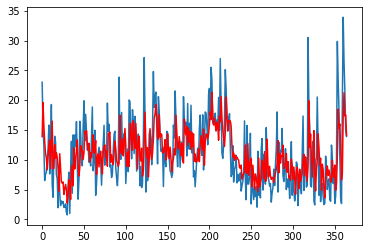

In [11]:
from math import sqrt
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()